In [0]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import math
import copy

from google.colab import drive
drive.mount('/content/drive')

class MLP(nn.Module):
  def __init__(self, n_units, init_scale=1.0):
    super(MLP, self).__init__()

    self._n_units = copy.copy(n_units)
    self._layers = []
    for i in range(1, len(n_units)):
      layer = nn.Linear(n_units[i-1], n_units[i], bias=False)
      variance = math.sqrt(2.0 / (n_units[i-1] + n_units[i]))
      layer.weight.data.normal_(0.0, init_scale * variance)
      self._layers.append(layer)

      name = 'fc%d' % i
      if i == len(n_units) - 1:
        name = 'fc'  # the prediction layer is just called fc
      self.add_module(name, layer)


  def forward(self, x):
    x = x.view(-1, self._n_units[0])
    out = self._layers[0](x)
    for layer in self._layers[1:]:
      out = F.relu(out)
      out = layer(out)
    return out

device = torch.device('cuda:0')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd drive/'My Drive'

[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive


In [0]:
def compute_acc(model, data_loader):
    correct_pred, num_examples = 0, 0
    model.eval()
    for i, (features, targets) in enumerate(data_loader):
        features, targets = features.to(device), targets.to(device)
        probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        assert predicted_labels.size() == targets.size()
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [0]:
def get_data_random(seed,train_bs=200, test_bs=1000):
  normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
  transform_train = transforms.Compose([
          transforms.ToTensor(),
          normalize])
  transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize])
  train_dataset = datasets.CIFAR10(root='data', 
                                train=True, 
                                transform=transform_train,
                                download=True)
  test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=transform_test,
                                download=True)
  np.random.seed(seed)

  probability_of_random = 1.0
  labels = np.array(train_dataset.targets) 
  mask = np.random.rand(len(labels)) <= probability_of_random #create mask of length labels, where entries drawn from [0,1].
  rnd_labels = np.random.choice(10, mask.sum())               #create random labels 1-10 of length of mask
  labels[mask] = rnd_labels
  labels = [int(x) for x in labels]
  train_dataset.targets = labels                              #assign new random labels to dataset
  
  train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=train_bs,
                          num_workers=4,
                          shuffle=True)
  test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=test_bs,
                         num_workers=4,
                         shuffle=False)
  return train_loader, test_loader

In [0]:
train_loader, test_loader = get_data_random(0, 128, 128)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
model = torch.load('MLP_3x512_fixedrandom_iter0_LongTraining')

In [0]:
train_acc = compute_acc(model, train_loader)        
print(f'train ACC: {train_acc:.2f}, seed: {0}')
        
test_acc = compute_acc(model, test_loader)        
print(f'Test ACC: {test_acc:.2f}')

train ACC: 99.96, seed: 0
Test ACC: 10.13


In [0]:
import math
import numpy as np
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt


def get_esd_plot(eigenvalues, weights, label):
    density, grids = density_generate(eigenvalues, weights)
    plt.semilogy(grids, density + 1.0e-7, label=label)
    plt.legend()
    #plt.plot(grids, density + 1.0e-7)
    plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
    plt.xlabel('Eigenvalue', fontsize=14, labelpad=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.axis([np.min(eigenvalues) - 1, np.max(eigenvalues) + 1, None, None])
    plt.axis([-5,20, None, None])
    plt.tight_layout()
    plt.show()

def compare_esd_plot(eigenvalues, weights, random_eigen, random_weight):
    density, grids = density_generate(eigenvalues, weights)
    random_density, random_grids = density_generate(random_eigen, random_weight)
    plt.clf()
    plt.semilogy(random_grids, random_density + 1.0e-7, label='random')
    plt.semilogy(grids, density + 1.0e-7, label='true')
    plt.legend()
    #plt.plot(grids, density + 1.0e-7)
    plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
    plt.xlabel('Eigenvlaue', fontsize=14, labelpad=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.axis([np.min(eigenvalues) - 1, np.max(eigenvalues) + 1, None, None])
    plt.axis([-1, 1, None, None])
    plt.tight_layout()
    plt.show()
    plt.savefig('example.pdf')


def density_generate(eigenvalues,
                     weights,
                     num_bins=10000,
                     sigma_squared=1e-5,
                     overhead=0.01):

    eigenvalues = np.array(eigenvalues)
    weights = np.array(weights)

    lambda_max = np.mean(np.max(eigenvalues, axis=1), axis=0) + overhead
    lambda_min = np.mean(np.min(eigenvalues, axis=1), axis=0) - overhead

    grids = np.linspace(lambda_min, lambda_max, num=num_bins)
    sigma = sigma_squared * max(1, (lambda_max - lambda_min))

    num_runs = eigenvalues.shape[0]
    density_output = np.zeros((num_runs, num_bins))

    for i in range(num_runs):
        for j in range(num_bins):
            x = grids[j]
            tmp_result = gaussian(eigenvalues[i, :], x, sigma)
            density_output[i, j] = np.sum(tmp_result * weights[i, :])
    density = np.mean(density_output, axis=0)
    normalization = np.sum(density) * (grids[1] - grids[0])
    density = density / normalization
    return density, grids


def gaussian(x, x0, sigma_squared):
    return np.exp(-(x0 - x)**2 /
                  (2.0 * sigma_squared)) / np.sqrt(2 * np.pi * sigma_squared)

In [0]:
from __future__ import print_function

import json
import os
import sys

import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from hessian import *

import math
import copy

# Settings

# set random seed to reproduce the work
torch.manual_seed(0)


# get dataset
train_loader, test_loader = get_data_random(0, train_bs=100, test_bs=1)
##############
# Get the hessian data
##############
batch_num = -1.

if batch_num == 1:
    for inputs, labels in train_loader:
        hessian_dataloader = (inputs, labels)
        break
else:
    hessian_dataloader = []
    for i, (inputs, labels) in enumerate(train_loader):
        hessian_dataloader.append((inputs, labels))
        if i == batch_num - 1:
            break

criterion = nn.CrossEntropyLoss()  # label loss

###################
# Get model checkpoint, get saving folder
###################

trace_list = []
eigen_list = []


model = model.to('cuda:0')
model.eval()
if batch_num == 1:
  hessian_comp = hessian(model,
                           criterion,
                           data=hessian_dataloader,
                           cuda=True)
else:
  hessian_comp = hessian(model,
                           criterion,
                           dataloader=hessian_dataloader,
                           cuda=True)

print(
    '********** finish data loading and begin Hessian computation **********')

top_eigenvalues, _ = hessian_comp.eigenvalues()
trace = hessian_comp.trace()
density_eigen, density_weight = hessian_comp.density(iter=100)

trace_list.append(trace)
eigen_list.append((density_eigen, density_weight))


print('\n***Top Eigenvalues: ', top_eigenvalues)
print('\n***Trace: ', np.mean(trace))


Files already downloaded and verified
Files already downloaded and verified
********** finish data loading and begin Hessian computation **********

***Top Eigenvalues:  [0.894433319568634]

***Trace:  129.55820337931314


In [0]:
np.save("MLP_3x512_randomlabels_eigens", density_eigen)
np.save("MLP_3x512_randomlabels_weights", density_weight)

In [0]:
random_eigen = np.load("MLP_3x512_randomlabels_eigens.npy")
random_weight = np.load("MLP_3x512_randomlabels_weights.npy")

In [0]:
true_eigen = np.load("MLP_3x512_truelabels_eigens.npy")
true_weight = np.load("MLP_3x512_truelabels_weights.npy")

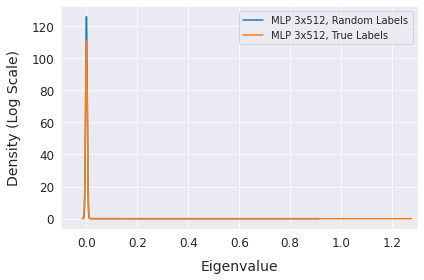

In [0]:
import seaborn as sns
sns.set_style("darkgrid")

density, grids = density_generate(random_eigen, random_weight)
density2, grids2 = density_generate(true_eigen, true_weight)
plt.plot(grids, density + 1.0e-7, label="MLP 3x512, Random Labels")
plt.plot(grids2, density2 + 1.0e-7, label="MLP 3x512, True Labels")
plt.legend()
plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
plt.xlabel('Eigenvalue', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.axis([np.min(density_eigen) - 1, np.max(density_eigen) + 1, None, None])
plt.axis([-0.1,1.3, None, None])
plt.tight_layout()

In [0]:
!pip install weightwatcher

2020-04-14 18:39:24,273 INFO 

python      version 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
numpy       version 1.18.2
tensforflow version 2.2.0-rc2
keras       version 2.3.1
2020-04-14 18:39:24,274 INFO Analyzing model
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


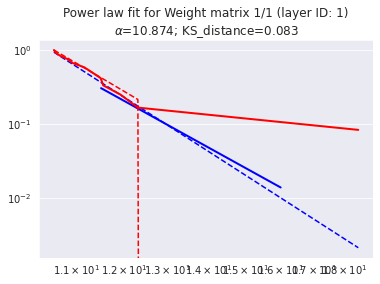

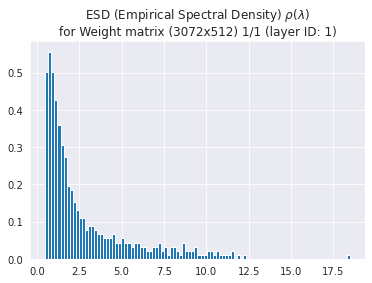

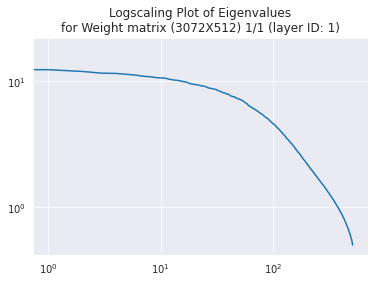

/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


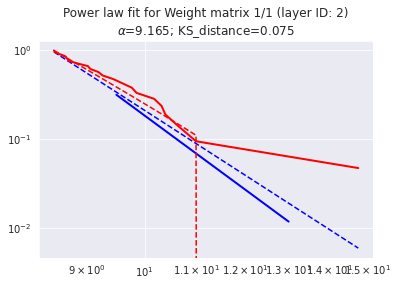

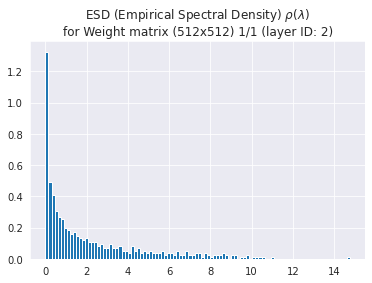

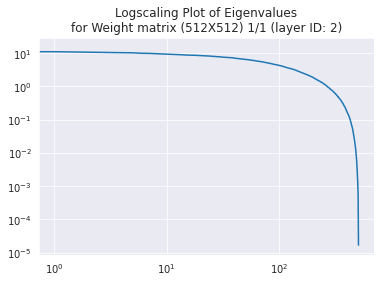

/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


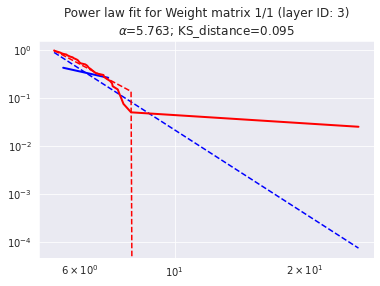

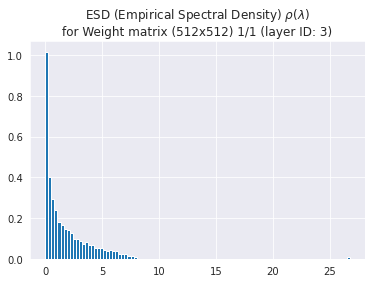

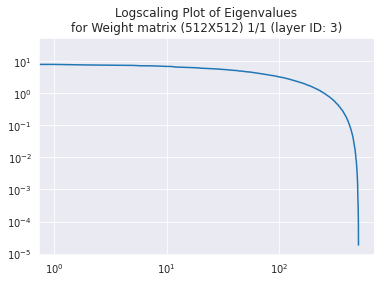

2020-04-14 18:39:38,574 INFO ### Printing results ###
2020-04-14 18:39:38,777 INFO Check: min: 0.042868861428838174, max: 0.17224949443885104, avg: 0.0978289544128938
2020-04-14 18:39:38,778 INFO Check compound: min: 0.042868861428838174, max: 0.17224949443885104, avg: 0.0978289544128938
2020-04-14 18:39:38,779 INFO CheckTF: min: False, max: False, avg: 0.0
2020-04-14 18:39:38,782 INFO CheckTF compound: min: 0.0, max: 0.0, avg: 0.0
2020-04-14 18:39:38,784 INFO Norm: min: 29.932231903076172, max: 38.01653289794922, avg: 33.93560791015625
2020-04-14 18:39:38,785 INFO Norm compound: min: 29.932231903076172, max: 38.01653289794922, avg: 33.93560791015625
2020-04-14 18:39:38,787 INFO LogNorm: min: 1.4761390686035156, max: 1.579972505569458, avg: 1.5285911560058594
2020-04-14 18:39:38,789 INFO LogNorm compound: min: 1.4761390686035156, max: 1.579972505569458, avg: 1.5285911560058594
2020-04-14 18:39:38,790 INFO Norm X: min: 63.06070327758789, max: 88.57030487060547, avg: 76.58692932128906
20

{'alpha': 8.600647371768432,
 'alpha_compound': 8.600647371768432,
 'alpha_weighted': 10.902393799959155,
 'alpha_weighted_compound': 10.902393799959155,
 'check': 0.0978289544128938,
 'checkTF': 0.0,
 'checkTF_compound': 0.0,
 'check_compound': 0.0978289544128938,
 'lognorm': 1.5285912,
 'lognormX': 1.8799545,
 'lognormX_compound': 1.8799545,
 'lognorm_compound': 1.5285912,
 'logpnorm': 10.97116781006937,
 'logpnorm_compound': 10.97116781006937,
 'norm': 33.935608,
 'normX': 76.58693,
 'normX_compound': 76.58693,
 'norm_compound': 33.935608}

In [0]:
import weightwatcher as ww
watcher = ww.WeightWatcher(model=model)
results = watcher.analyze(alphas=True, plot=True)

watcher.get_summary()